# **PROJECT JARINGAN SYARAF TIRUAN - BACPROPAGATION**

## **Library**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ucimlrepo import fetch_ucirepo
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
from imblearn.combine import SMOTEENN
from scipy.stats import mstats
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

seed = 42

In [5]:
# Activating GPU if available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("GPU is activated")
    except:
        print("Could not set memory growth")

GPU is activated


## **Data**

In [6]:
# fetch dataset 
default_of_credit_card_clients = fetch_ucirepo(id=350) 

# data (as pandas dataframes) 
X = default_of_credit_card_clients.data.features 
y = default_of_credit_card_clients.data.targets 

# metadata 
print(default_of_credit_card_clients.metadata) 

# variable information 
print(default_of_credit_card_clients.variables) 

{'uci_id': 350, 'name': 'Default of Credit Card Clients', 'repository_url': 'https://archive.ics.uci.edu/dataset/350/default+of+credit+card+clients', 'data_url': 'https://archive.ics.uci.edu/static/public/350/data.csv', 'abstract': "This research aimed at the case of customers' default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods.", 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 30000, 'num_features': 23, 'feature_types': ['Integer', 'Real'], 'demographics': ['Sex', 'Education Level', 'Marital Status', 'Age'], 'target_col': ['Y'], 'index_col': ['ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C55S3H', 'creators': ['I-Cheng Yeh'], 'intro_paper': {'ID': 365, 'type': 'NATIVE', 'title': 'The comparisons of data mining techniques for the predictive accuracy of 

This research employed a binary variable, default payment **(Yes = 1, No = 0)**, as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- **X1**: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- **X2**: Gender (1 = male; 2 = female).
- **X3**: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- **X4**: Marital status (1 = married; 2 = single; 3 = others).
- **X5**: Age (year).
- **X6 - X11**: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- **X12-X17**: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- **X18-X23**: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.

In [7]:
X.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


### **Removing Invalid Values**
After checking, several data were found that did not match the scale in the variable description. After inspection, several data points were found to be off-scale in the variable descriptions. This data was found in variables X3 and X4.

In [8]:
# Handle invalid values in X2 and X4 by setting them to NaN
X.loc[~X['X3'].isin([1, 2, 3, 4]), 'X3'] = np.nan
X.loc[~X['X4'].isin([1, 2, 3]), 'X4'] = np.nan

print("X3 value counts after cleaning:")
print(X['X3'].value_counts(dropna=False))
print("\nX4 value counts after cleaning:")
print(X['X4'].value_counts(dropna=False))

X3 value counts after cleaning:
2.0    14030
1.0    10585
3.0     4917
NaN      345
4.0      123
Name: X3, dtype: int64

X4 value counts after cleaning:
2.0    15964
1.0    13659
3.0      323
NaN       54
Name: X4, dtype: int64


In [9]:
data = pd.concat([X, y], axis=1)
data

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,20000,2,2.0,1.0,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2.0,2.0,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2.0,2.0,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2.0,1.0,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2.0,1.0,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,220000,1,3.0,1.0,39,0,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,150000,1,3.0,2.0,43,-1,-1,-1,-1,0,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,30000,1,2.0,2.0,37,4,3,2,-1,0,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,80000,1,3.0,1.0,41,1,-1,0,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


### **Statistic Descriptive**

In [10]:
data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
count,30000.000000,30000.000000,29655.000000,29946.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.817164,1.554665,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.711283,0.518259,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,1.000000,1.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,4.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
data.isnull().sum()

X1       0
X2       0
X3     345
X4      54
X5       0
X6       0
X7       0
X8       0
X9       0
X10      0
X11      0
X12      0
X13      0
X14      0
X15      0
X16      0
X17      0
X18      0
X19      0
X20      0
X21      0
X22      0
X23      0
Y        0
dtype: int64

In [12]:
missing_percentage = data.isnull().mean() * 100
missing_percentage

X1     0.00
X2     0.00
X3     1.15
X4     0.18
X5     0.00
X6     0.00
X7     0.00
X8     0.00
X9     0.00
X10    0.00
X11    0.00
X12    0.00
X13    0.00
X14    0.00
X15    0.00
X16    0.00
X17    0.00
X18    0.00
X19    0.00
X20    0.00
X21    0.00
X22    0.00
X23    0.00
Y      0.00
dtype: float64

In [13]:
data.duplicated().sum()

35

In [14]:
duplicate_precentage = (data.duplicated().sum() / len(data)) * 100
print(f"Percentage of duplicate rows: {duplicate_precentage:.2f}%")

Percentage of duplicate rows: 0.12%


## **EDA**

In [15]:
num_features = data.drop(['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'Y'], axis=1).columns
cat_features = data[['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']].columns

print("Numerical Features:", num_features.tolist())
print("Categorical Features:", cat_features.tolist())

Numerical Features: ['X1', 'X5', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23']
Categorical Features: ['X2', 'X3', 'X4', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11']


### **Feature Distribution**

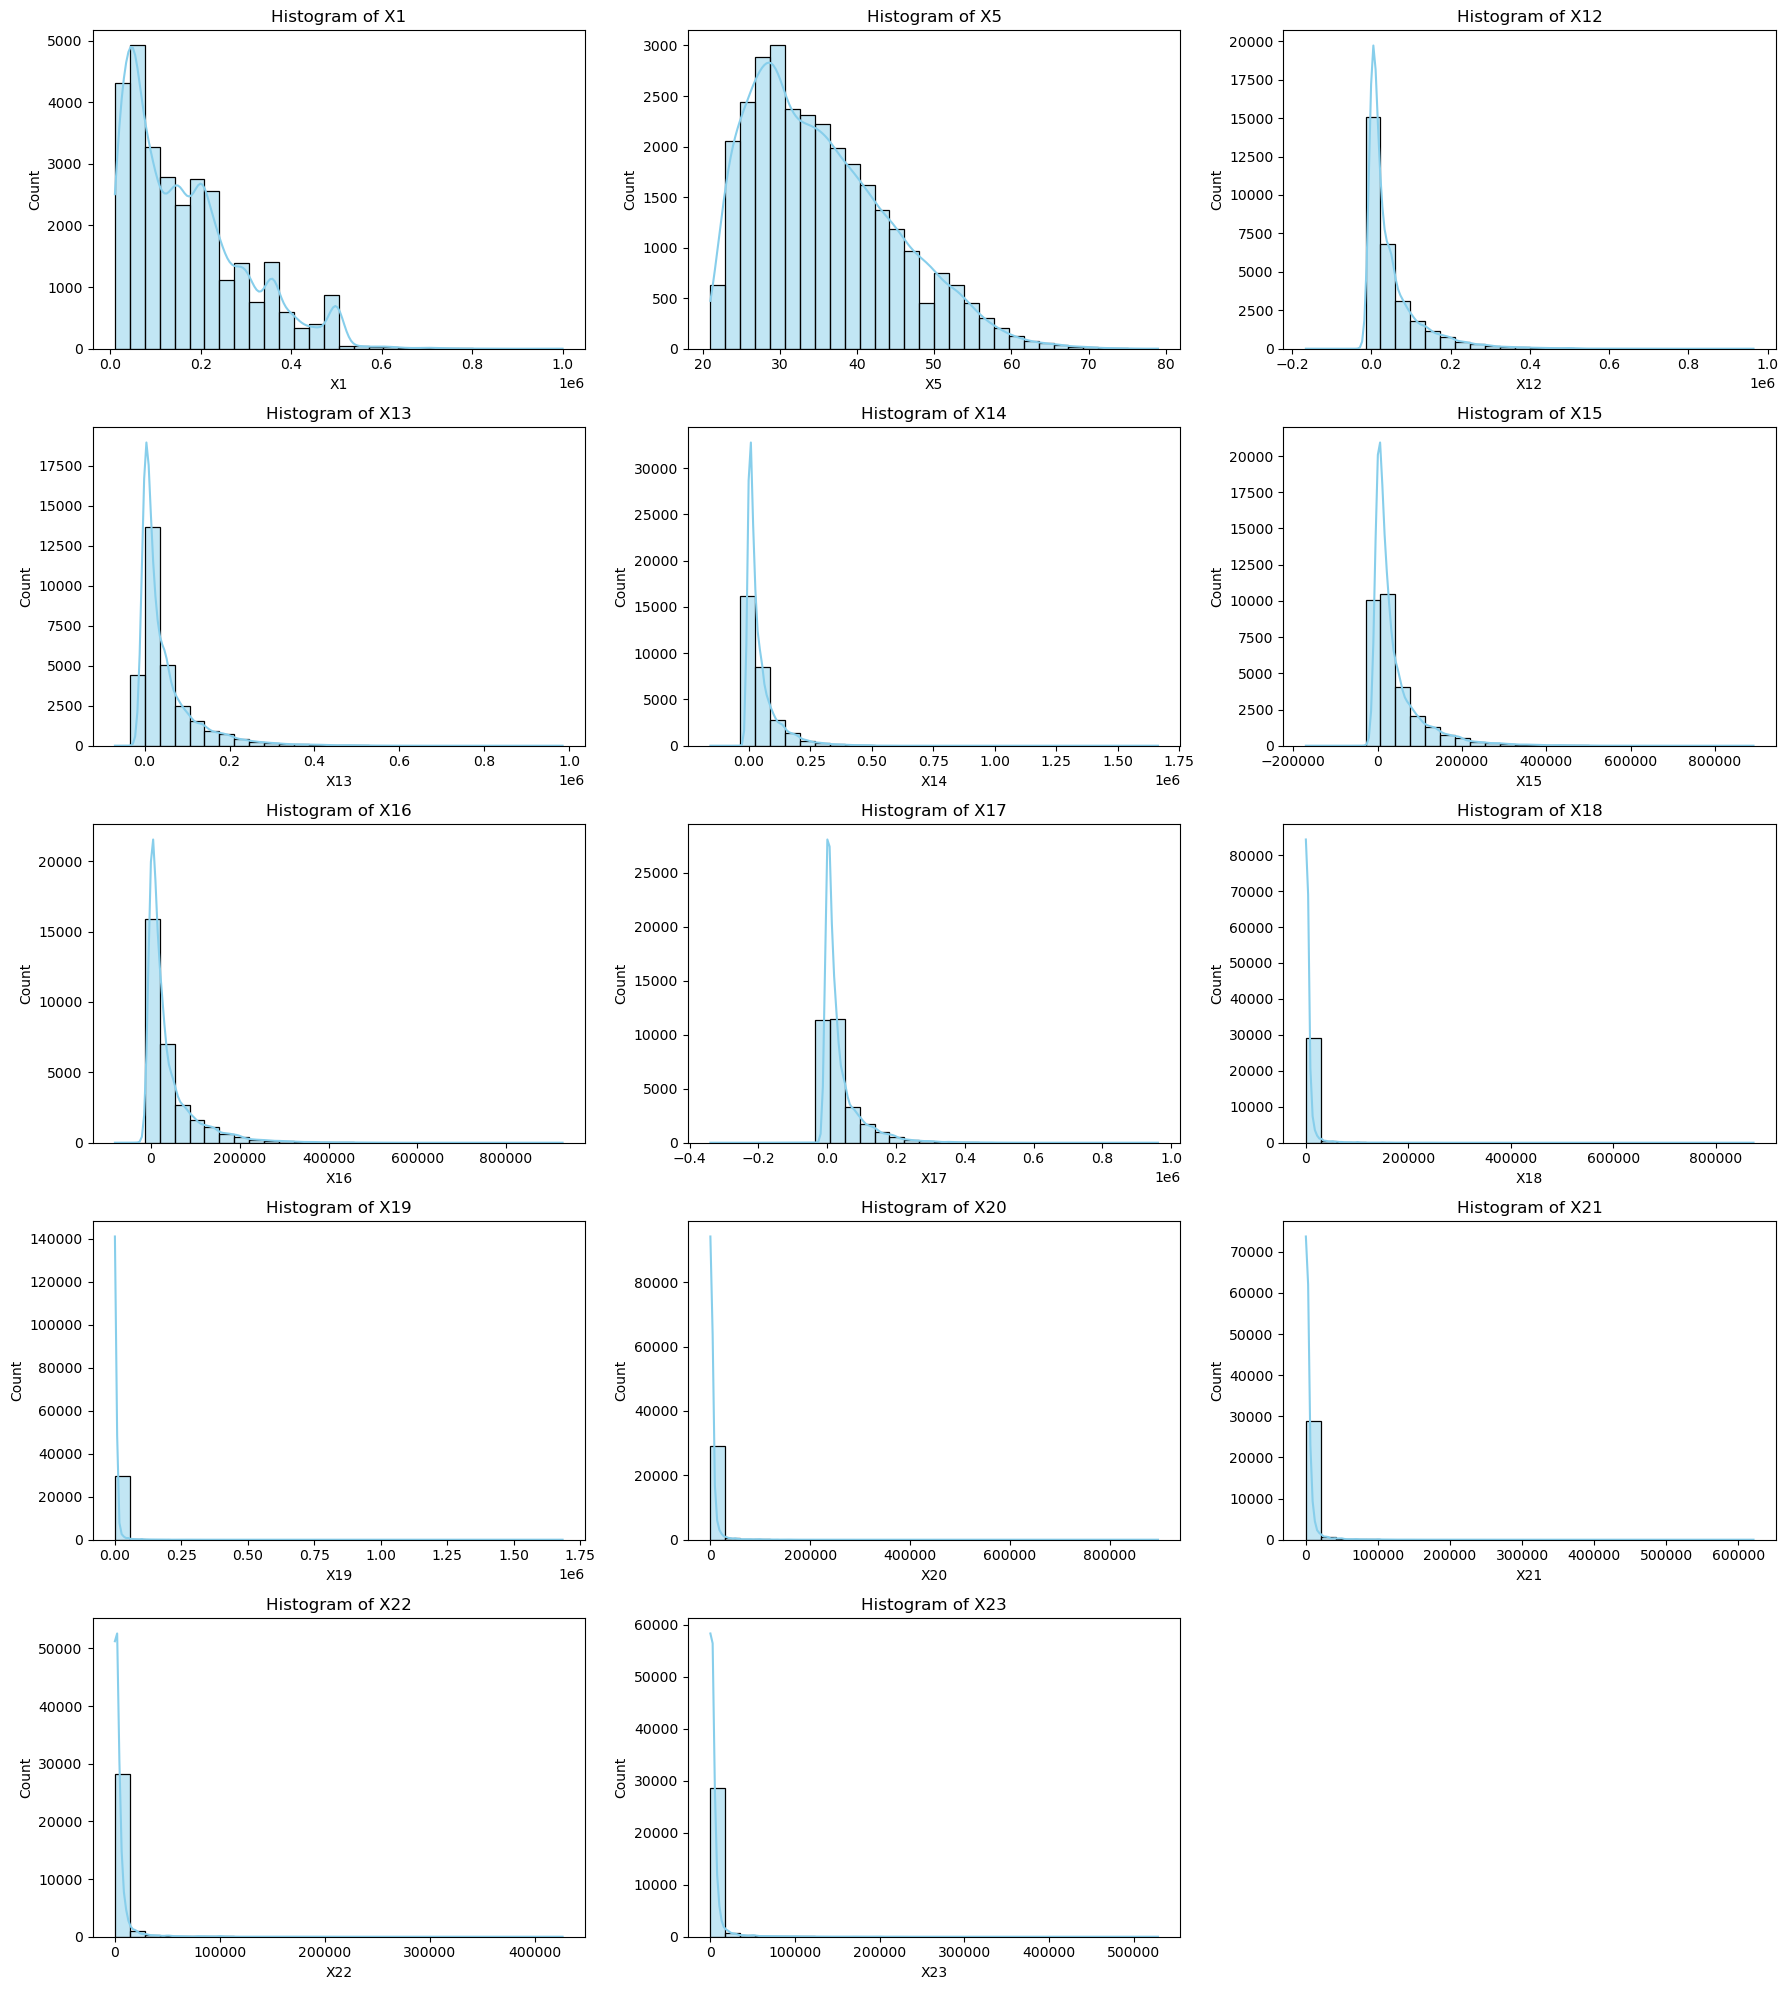

In [16]:
# visualize the distribution of the numerical features
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    sns.histplot(data[column], bins=30, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f'Histogram of {column}')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

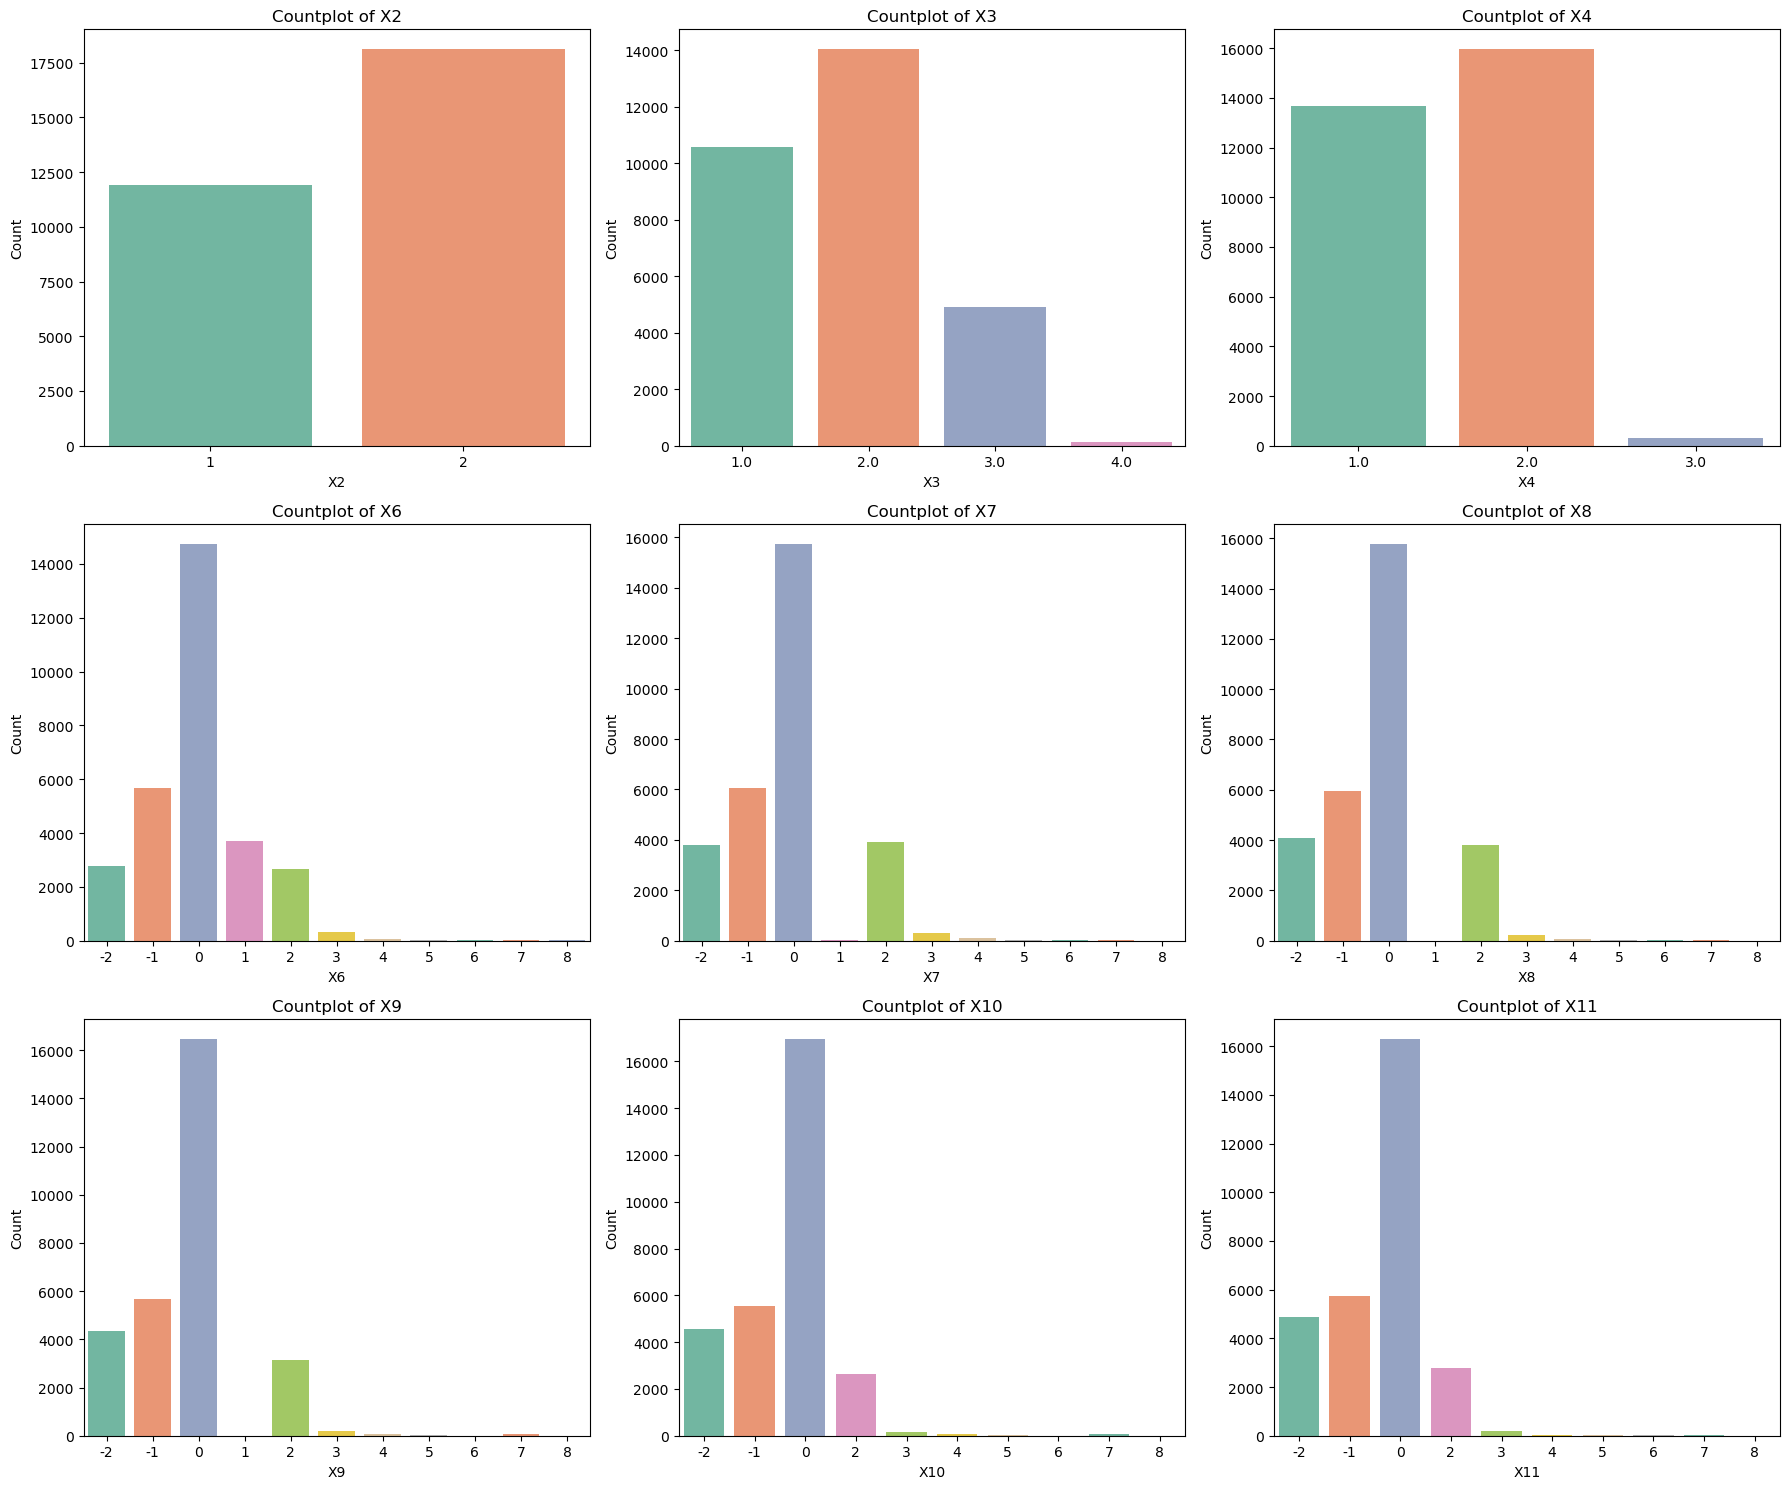

In [17]:
# visualization of categorical features
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten()
for i, column in enumerate(cat_features):
    sns.countplot(x=data[column], ax=axes[i], palette='Set2')
    axes[i].set_title(f'Countplot of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

### **Boxplot**

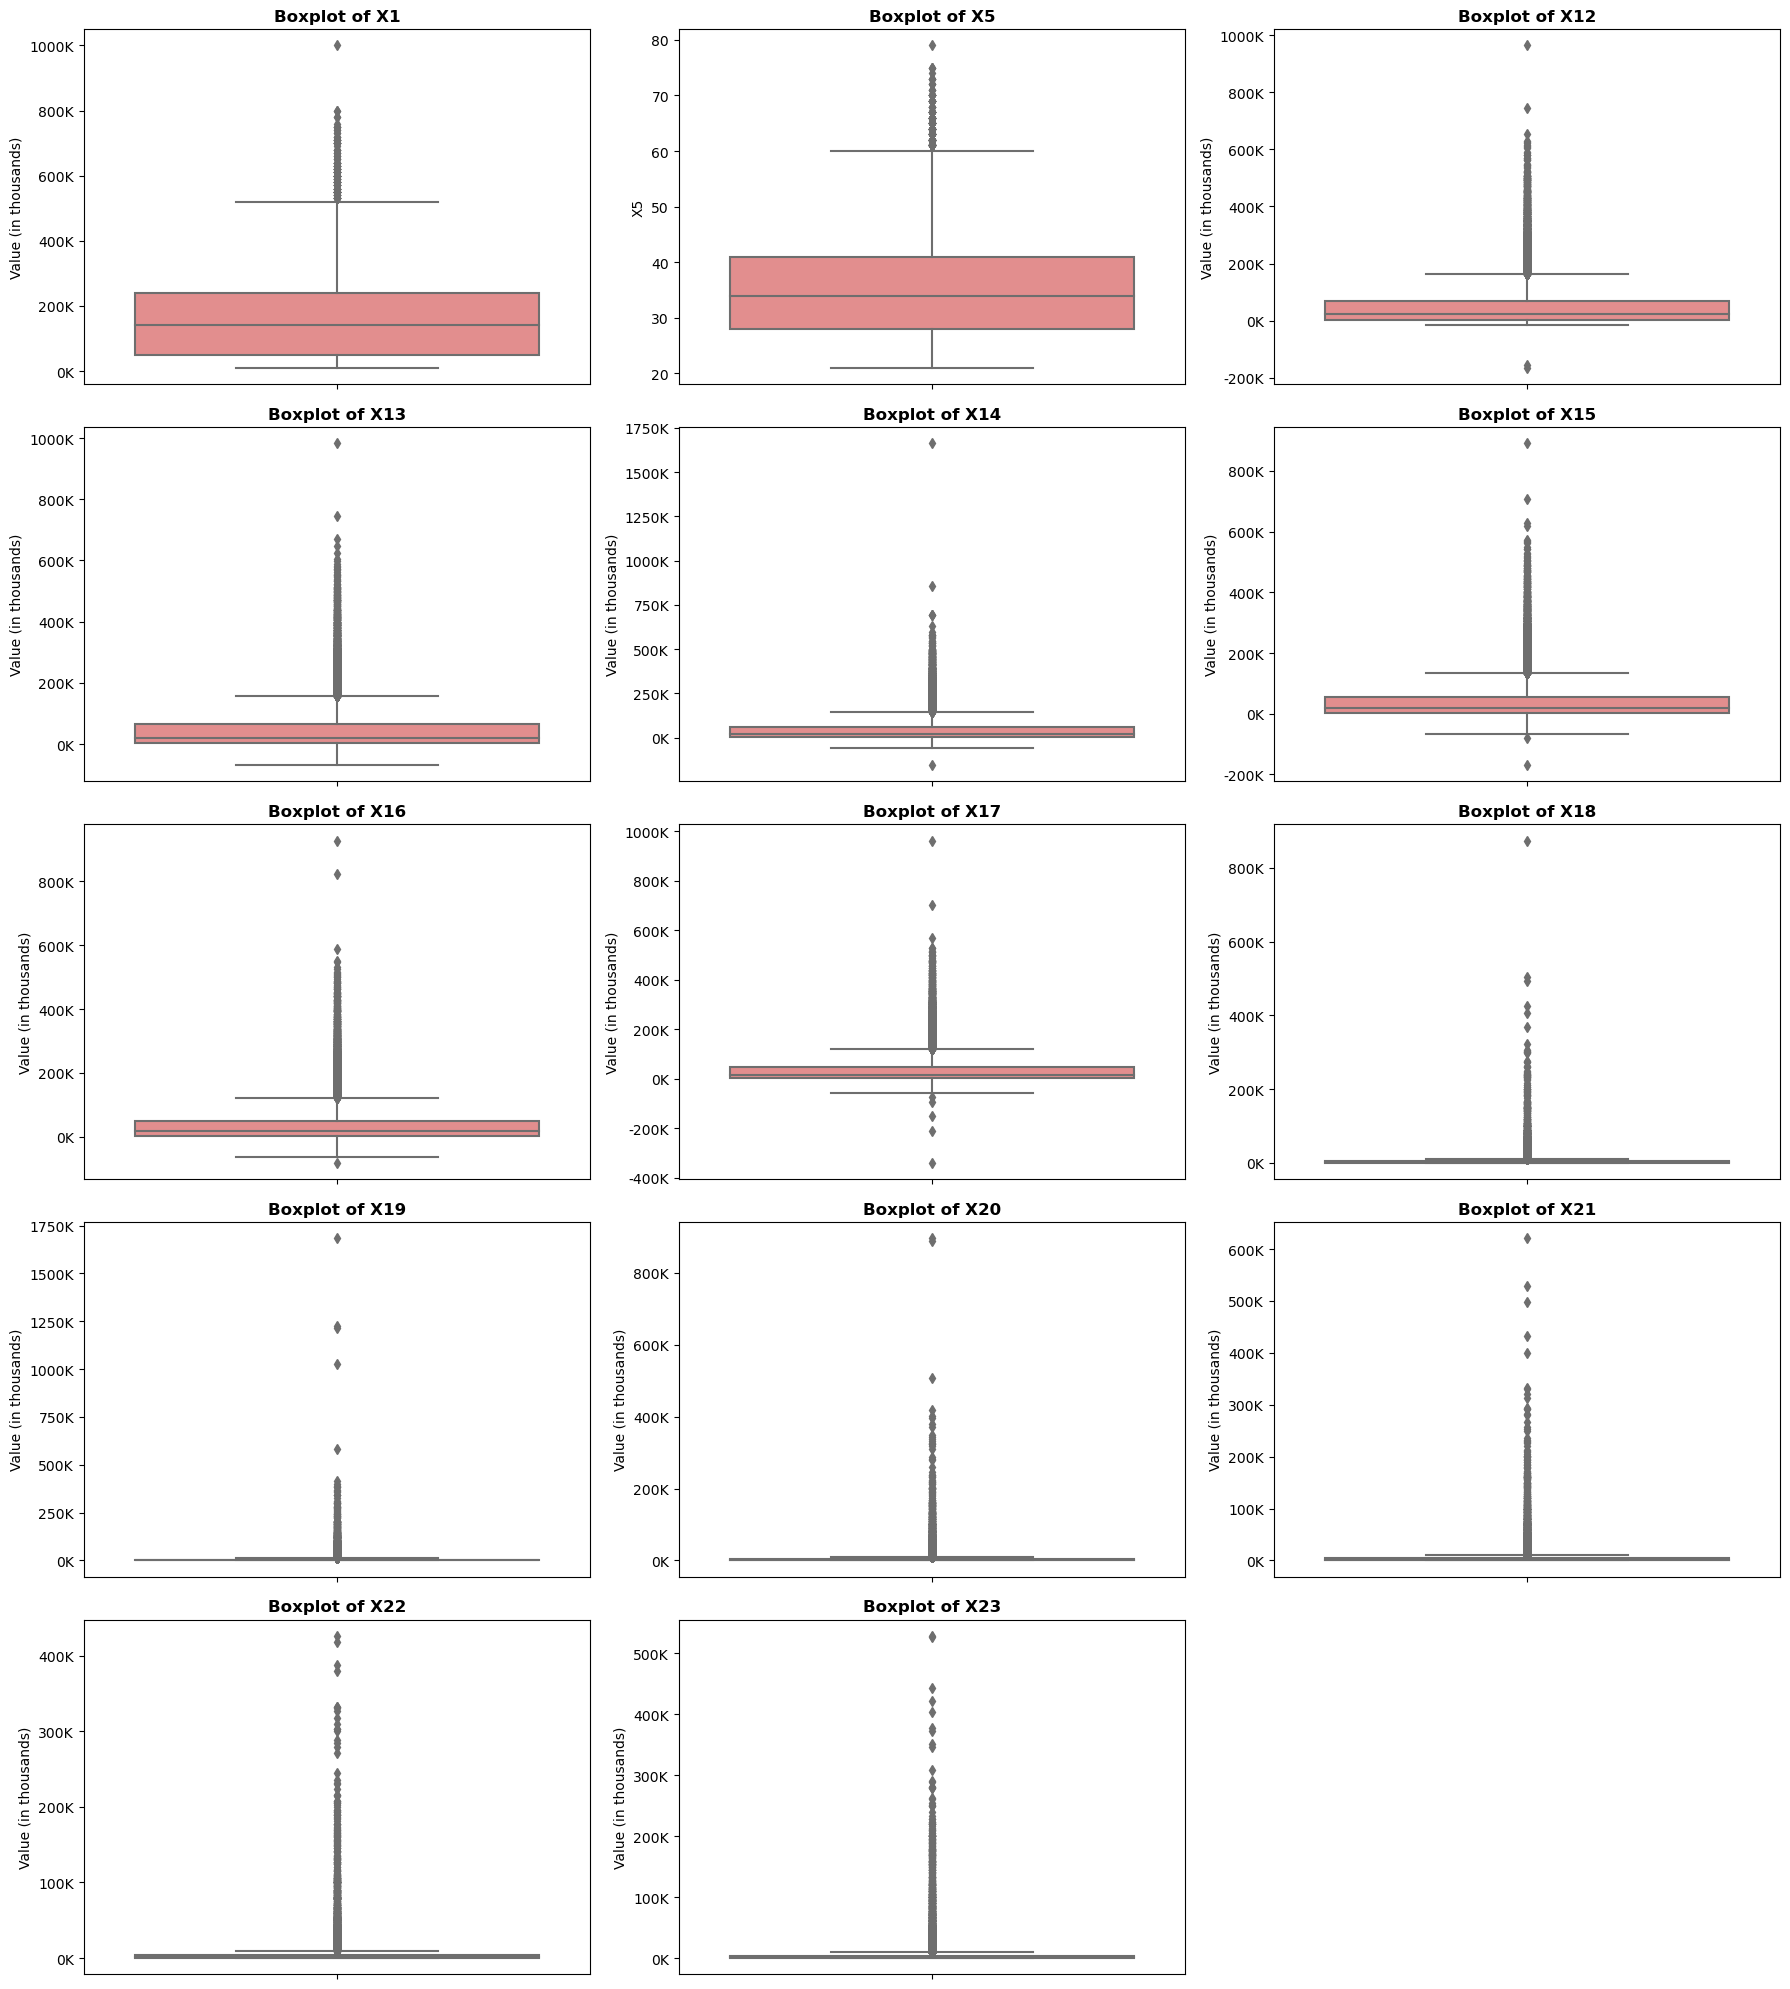

In [18]:
# Boxplot for checking outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    # Create boxplot
    sns.boxplot(y=data[column], ax=axes[i], color='lightcoral')
    axes[i].set_title(f'Boxplot of {column}', fontsize=12, fontweight='bold')
    
    # Format y-axis for better readability
    if data[column].max() > 10000:
        axes[i].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}K'))
        axes[i].set_ylabel('Value (in thousands)')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

### **Target Distribution**

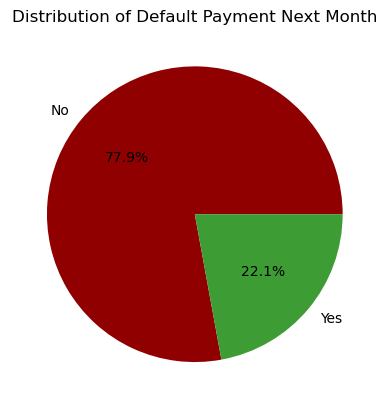

In [19]:
# visualize the distribution of the target variable
plt.pie(data['Y'].value_counts(), labels=['No', 'Yes'], autopct='%1.1f%%', colors=['#900000', '#3e9c35'])
plt.title('Distribution of Default Payment Next Month')
plt.show()

### **Correlation**

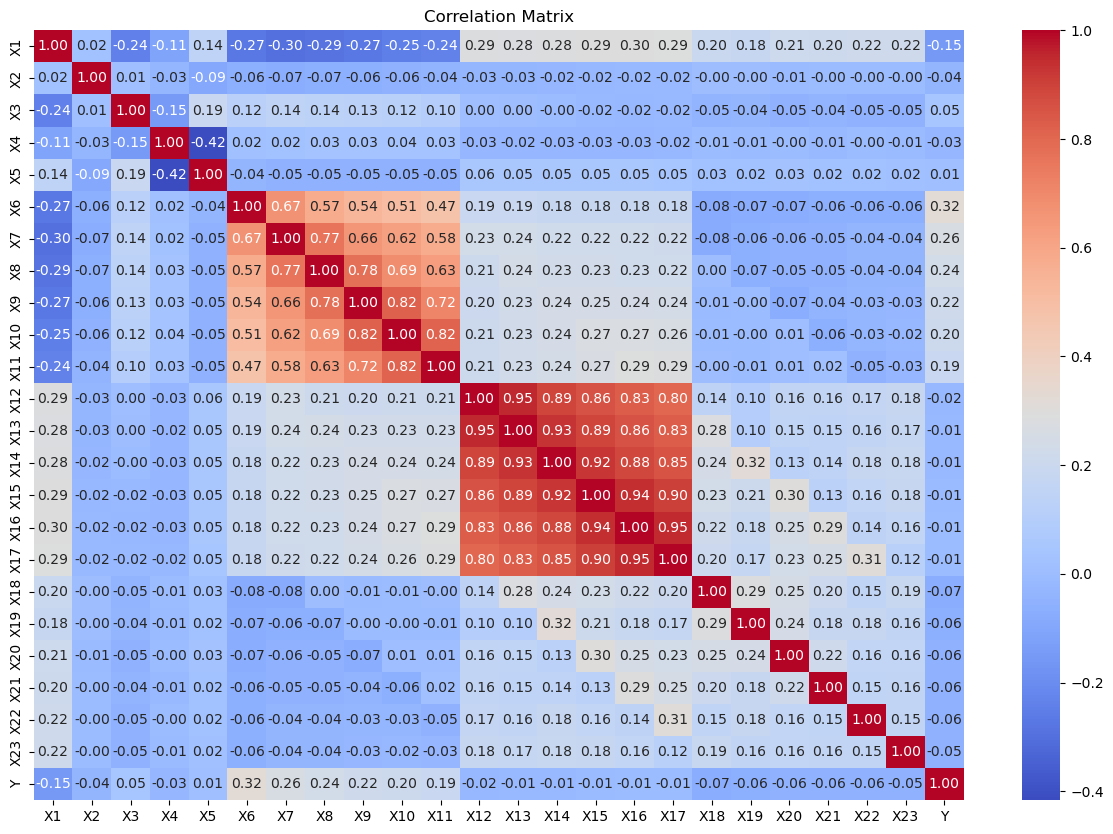

In [20]:
# Correlation matrix
plt.figure(figsize=(15,10))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

## **Preprocessing**

### **Handling Missing Values**

In [21]:
imputer = SimpleImputer(strategy='most_frequent')
data[['X3', 'X4']] = imputer.fit_transform(data[['X3', 'X4']])

In [22]:
data.isnull().sum() 

X1     0
X2     0
X3     0
X4     0
X5     0
X6     0
X7     0
X8     0
X9     0
X10    0
X11    0
X12    0
X13    0
X14    0
X15    0
X16    0
X17    0
X18    0
X19    0
X20    0
X21    0
X22    0
X23    0
Y      0
dtype: int64

### **Handling Outliers**

In [23]:
# handling outliers using winsorization
data_winsorized = data.copy()
for col in num_features:
    Q1 = data_winsorized[col].quantile(0.25)
    Q3 = data_winsorized[col].quantile(0.75)
    data_winsorized[col] = data_winsorized[col].clip(lower=Q1, upper=Q3)

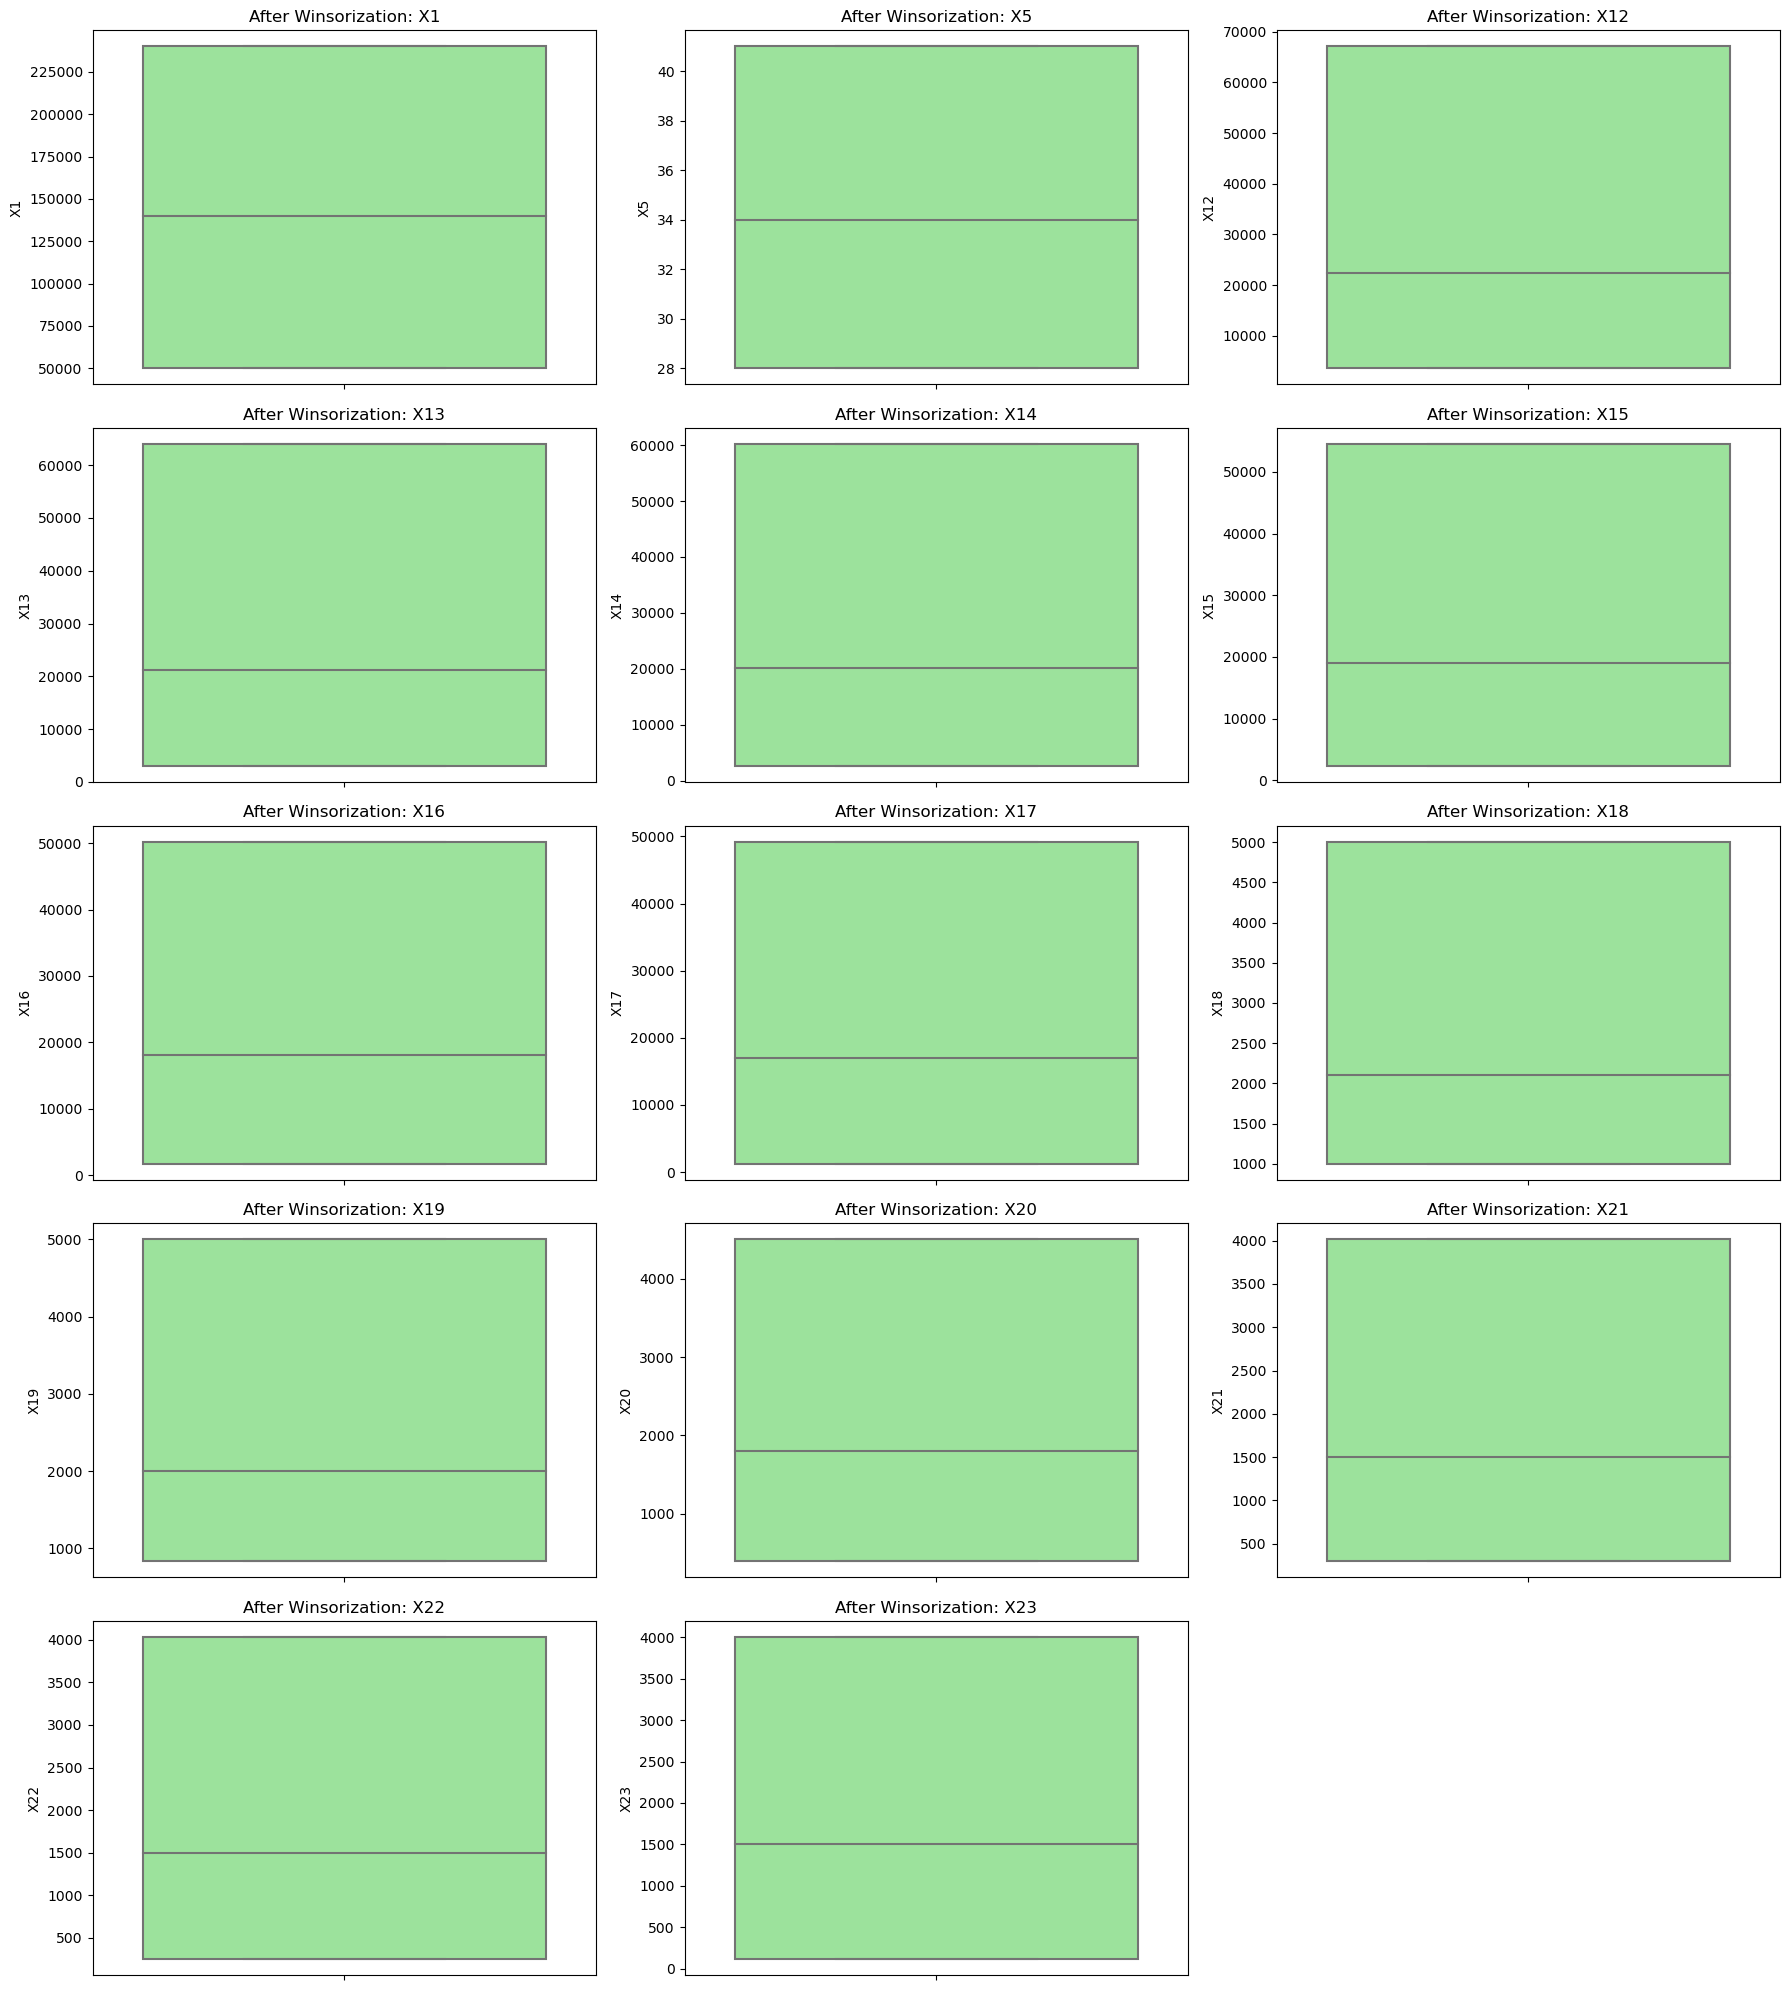

In [24]:
# boxplot after handling outliers
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(data_winsorized[num_features].columns):
    sns.boxplot(y=data_winsorized[column], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'After Winsorization: {column}')
# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)
plt.tight_layout()
plt.show()

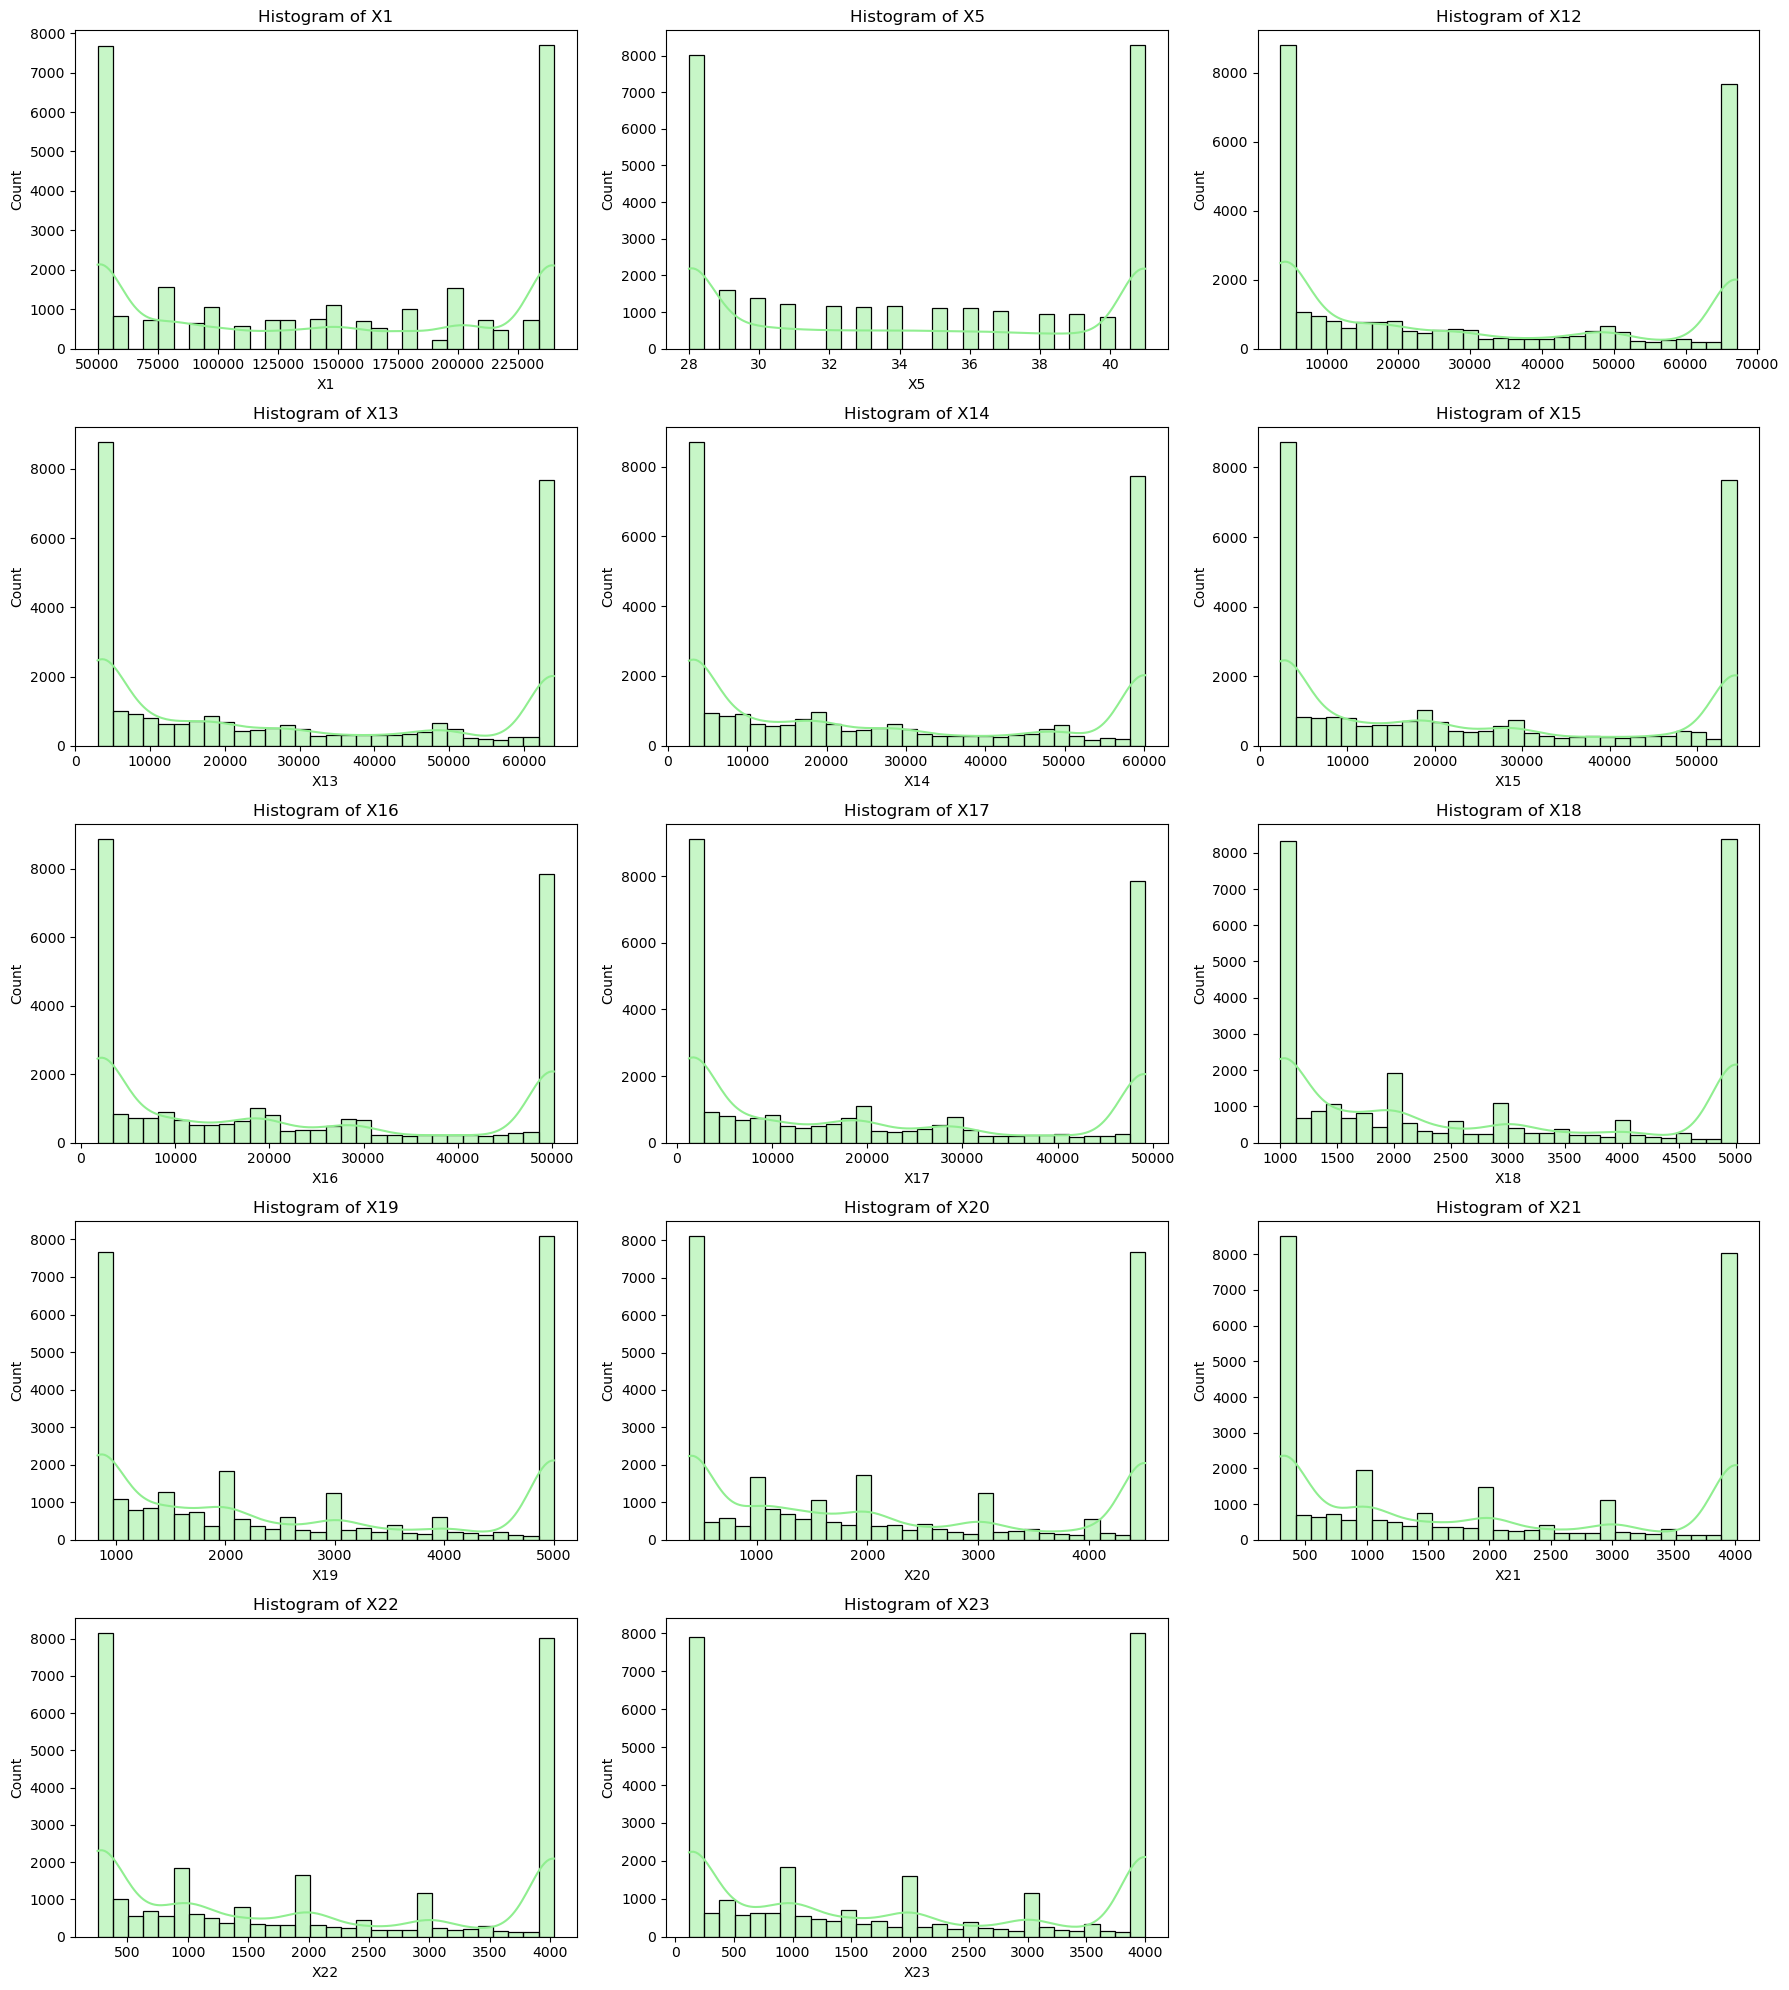

In [25]:
# visualize the distribution of the numerical features
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(18, 20))
axes = axes.flatten()
for i, column in enumerate(num_features):
    sns.histplot(data_winsorized[column], bins=30, kde=True, ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Histogram of {column}')

# Hide unused subplots
for j in range(len(num_features), len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

In [26]:
# Add this after your current outlier handling

### **Outlier Handling Effectiveness Analysis**

def analyze_outlier_handling(data_original, data_winsorized, numerical_features):
    """Analyze the effectiveness of outlier handling"""
    
    print("=== OUTLIER HANDLING EFFECTIVENESS ANALYSIS ===\n")
    
    outlier_analysis = []
    
    for col in numerical_features:
        # Original data statistics
        orig_q1 = data_original[col].quantile(0.25)
        orig_q3 = data_original[col].quantile(0.75)
        orig_iqr = orig_q3 - orig_q1
        orig_lower = orig_q1 - 1.5 * orig_iqr
        orig_upper = orig_q3 + 1.5 * orig_iqr
        orig_outliers = ((data_original[col] < orig_lower) | (data_original[col] > orig_upper)).sum()
        
        # Winsorized data statistics
        wins_q1 = data_winsorized[col].quantile(0.25)
        wins_q3 = data_winsorized[col].quantile(0.75)
        wins_iqr = wins_q3 - wins_q1
        wins_lower = wins_q1 - 1.5 * wins_iqr
        wins_upper = wins_q3 + 1.5 * wins_iqr
        wins_outliers = ((data_winsorized[col] < wins_lower) | (data_winsorized[col] > wins_upper)).sum()
        
        # Calculate reduction
        outlier_reduction = orig_outliers - wins_outliers
        reduction_pct = (outlier_reduction / orig_outliers * 100) if orig_outliers > 0 else 0
        
        outlier_analysis.append({
            'Feature': col,
            'Original_Outliers': orig_outliers,
            'After_Outliers': wins_outliers,
            'Reduction': outlier_reduction,
            'Reduction_Pct': reduction_pct
        })
        
        print(f"{col}:")
        print(f"  Original outliers: {orig_outliers}")
        print(f"  After winsorization: {wins_outliers}")
        print(f"  Reduction: {outlier_reduction} ({reduction_pct:.1f}%)")
        print(f"  Range change: [{data_original[col].min():.0f}, {data_original[col].max():.0f}] → [{data_winsorized[col].min():.0f}, {data_winsorized[col].max():.0f}]")
        print()
    
    # Summary statistics
    df_analysis = pd.DataFrame(outlier_analysis)
    print("=== SUMMARY ===")
    print(f"Average outlier reduction: {df_analysis['Reduction_Pct'].mean():.1f}%")
    print(f"Features with >90% reduction: {(df_analysis['Reduction_Pct'] > 90).sum()}")
    print(f"Features with <50% reduction: {(df_analysis['Reduction_Pct'] < 50).sum()}")
    
    return df_analysis

# Run analysis
outlier_effectiveness = analyze_outlier_handling(data, data_winsorized, num_features)

=== OUTLIER HANDLING EFFECTIVENESS ANALYSIS ===

X1:
  Original outliers: 167
  After winsorization: 0
  Reduction: 167 (100.0%)
  Range change: [10000, 1000000] → [50000, 240000]

X5:
  Original outliers: 272
  After winsorization: 0
  Reduction: 272 (100.0%)
  Range change: [21, 79] → [28, 41]

X12:
  Original outliers: 2400
  After winsorization: 0
  Reduction: 2400 (100.0%)
  Range change: [-165580, 964511] → [3559, 67091]

X13:
  Original outliers: 2395
  After winsorization: 0
  Reduction: 2395 (100.0%)
  Range change: [-69777, 983931] → [2985, 64006]

X14:
  Original outliers: 2469
  After winsorization: 0
  Reduction: 2469 (100.0%)
  Range change: [-157264, 1664089] → [2666, 60165]

X15:
  Original outliers: 2622
  After winsorization: 0
  Reduction: 2622 (100.0%)
  Range change: [-170000, 891586] → [2327, 54506]

X16:
  Original outliers: 2725
  After winsorization: 0
  Reduction: 2725 (100.0%)
  Range change: [-81334, 927171] → [1763, 50190]

X17:
  Original outliers: 2693
  

### **Feature Engineering**

In [49]:
def create_credit_features(data):
    """Create domain-specific features for credit default prediction"""
    
    data = data.copy()
    
    # === CREDIT UTILIZATION FEATURES ===
    # Most important financial indicator
    data['credit_utilization_recent'] = data['X12'] / (data['X1'] + 1)
    data['credit_utilization_avg'] = (
        data[['X12', 'X13', 'X14', 'X15', 'X16', 'X17']].mean(axis=1) / 
        (data['X1'] + 1)
    )
    
    # === PAYMENT BEHAVIOR FEATURES ===
    # Payment-to-bill ratios (ability to pay)
    bill_cols = ['X12', 'X13', 'X14', 'X15', 'X16', 'X17']
    payment_cols = ['X18', 'X19', 'X20', 'X21', 'X22', 'X23']
    
    # Average payment ratio
    data['avg_payment_ratio'] = (
        data[payment_cols].sum(axis=1) / 
        (data[bill_cols].sum(axis=1) + 1)
    )
    
    # === PAYMENT DELAY FEATURES ===
    delay_cols = ['X6', 'X7', 'X8', 'X9', 'X10', 'X11']
    
    # Delay frequency and severity
    data['delay_frequency'] = (data[delay_cols] > 0).sum(axis=1)
    data['severe_delay_count'] = (data[delay_cols] >= 2).sum(axis=1)
    data['max_delay'] = data[delay_cols].max(axis=1)

    # Recent vs historical delays (trend)
    data['recent_delay_trend'] = (
        data[['X6', 'X7', 'X8']].mean(axis=1) - 
        data[['X9', 'X10', 'X11']].mean(axis=1)
    )
    
    # === FINANCIAL STABILITY FEATURES ===
    # Bill amount trends
    data['bill_trend'] = data['X12'] - data['X17']
    data['bill_volatility'] = data[bill_cols].std(axis=1)

    # Payment consistency
    data['payment_volatility'] = data[payment_cols].std(axis=1)
    data['payment_trend'] = data['X18'] - data['X23']
    
    # === DEMOGRAPHIC RISK FEATURES ===
    # Age-based risk categories
    data['age_risk_young'] = (data['X5'] <= 30).astype(int)
    data['age_risk_senior'] = (data['X5'] >= 60).astype(int)
    
    # Education risk (higher education = lower risk)
    data['education_risk'] = data['X3'].map({1: 0, 2: 0, 3: 1, 4: 1})

    # === INTERACTION FEATURES ===
    # Credit limit vs age
    data['credit_per_age'] = data['X1'] / (data['X5'] + 1)

    return data

# Apply feature engineering to winsorized data
print("Creating enhanced features...")
data = create_credit_features(data_winsorized)

print(f"Original features: {data_winsorized.shape[1]}")
print(f"Enhanced features: {data.shape[1]}")
print(f"New features added: {data.shape[1] - data_winsorized.shape[1]}")

# Display new feature names
new_features = [col for col in data.columns if col not in data_winsorized.columns]
print(f"\nNew features created:")
for i, feature in enumerate(new_features, 1):
    print(f"{i:2d}. {feature}")

Creating enhanced features...
Original features: 24
Enhanced features: 39
New features added: 15

New features created:
 1. credit_utilization_recent
 2. credit_utilization_avg
 3. avg_payment_ratio
 4. delay_frequency
 5. severe_delay_count
 6. max_delay
 7. recent_delay_trend
 8. bill_trend
 9. bill_volatility
10. payment_volatility
11. payment_trend
12. age_risk_young
13. age_risk_senior
14. education_risk
15. credit_per_age


### **Splitting Data**

In [50]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Y', axis=1),
    data['Y'],
    test_size=0.2,
    random_state=seed,
    stratify=data['Y']
)

### **Imbalance Data Handling**

In [51]:
# Apply SMOTEENN to handle imbalanced data
smoteenn = SMOTEENN(random_state=seed)
X_train, y_train = smoteenn.fit_resample(X_train, y_train)

print("Before SMOTEENN:")
print(f"Class 0: {(y_train == 0).sum()}")
print(f"Class 1: {(y_train == 1).sum()}")
print(f"Total samples: {len(y_train)}")

Before SMOTEENN:
Class 0: 8463
Class 1: 12926
Total samples: 21389


In [30]:
# adasyn = ADASYN(random_state=seed)
# X_train, y_train = adasyn.fit_resample(X_train, y_train)

### **Scaling**

In [52]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## **Modelling**

In [53]:
patience = 10
batch_size = 32

In [55]:
model = keras.Sequential([
    # input layer
    layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # hidden layers
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    
    # output layer
    layers.Dense(1, activation='sigmoid')
])

# Set seeds for reproducibility
tf.random.set_seed(seed)

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

In [56]:
model.fit(X_train, y_train,
          epochs=100,
          batch_size=batch_size, 
          validation_split=0.2,
          verbose=1, 
          callbacks=[
              EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
              ModelCheckpoint('best_model.h5', save_best_only=True)])

Epoch 1/100
535/535 [==============================] - 5s 9ms/step - loss: 0.5101 - accuracy: 0.7680 - val_loss: 0.3644 - val_accuracy: 0.8303
Epoch 2/100
535/535 [==============================] - 4s 8ms/step - loss: 0.4449 - accuracy: 0.7976 - val_loss: 0.3711 - val_accuracy: 0.8130
Epoch 3/100
535/535 [==============================] - 4s 8ms/step - loss: 0.4226 - accuracy: 0.8094 - val_loss: 0.3030 - val_accuracy: 0.8808
Epoch 4/100
535/535 [==============================] - 4s 8ms/step - loss: 0.4142 - accuracy: 0.8100 - val_loss: 0.3088 - val_accuracy: 0.8633
Epoch 5/100
535/535 [==============================] - 4s 8ms/step - loss: 0.4141 - accuracy: 0.8146 - val_loss: 0.2754 - val_accuracy: 0.8964
Epoch 6/100
535/535 [==============================] - 4s 8ms/step - loss: 0.3981 - accuracy: 0.8243 - val_loss: 0.3062 - val_accuracy: 0.8583
Epoch 7/100
535/535 [==============================] - 4s 8ms/step - loss: 0.4011 - accuracy: 0.8227 - val_loss: 0.2807 - val_accuracy: 0.8820

In [57]:
# Make predictions
model.load_weights('best_model.h5')
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Additional metrics
print("Additional Metrics:")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")

188/188 [==============================] - 1s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      4673
           1       0.42      0.60      0.49      1327

    accuracy                           0.73      6000
   macro avg       0.64      0.68      0.65      6000
weighted avg       0.77      0.73      0.74      6000

Additional Metrics:
Precision: 0.4179
Recall: 0.6021
F1-Score: 0.4934


In [58]:
print(confusion_matrix(y_test, (model.predict(X_test) > 0.5).astype("int32")))

188/188 [==============================] - 1s 3ms/step
[[3560 1113]
 [ 528  799]]
